In [4]:
import joblib
import pandas as pd

# Load model and data
model = joblib.load("outputs/hotel_rf_model.joblib")   # Random Forest model
X_sample = pd.read_csv("engineered_features_v4.csv")  # same final dataset

# Drop target and unused date column
drop_cols = ['is_canceled', 'reservation_status_date']
X_sample = X_sample.drop(columns=[col for col in drop_cols if col in X_sample.columns], errors='ignore')

# Get churn probabilities
y_prob = model.predict_proba(X_sample)[:, 1]

# print("✅ y_prob generated successfully")
print("Shape:", y_prob.shape)
print("Range:", y_prob.min(), "→", y_prob.max())
print("Mean:", y_prob.mean())


Shape: (117399,)
Range: 0.007712122402609893 → 0.9990445876913993
Mean: 0.37510261860779337


In [5]:
# ============================================================
# Business Simulation & Strategic Layer
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume you already have churn probabilities
# Example: y_prob = model.predict_proba(X_test)[:, 1]
# and user_ids or indices
n = len(y_prob)
df_sim = pd.DataFrame({
    "user_id": np.arange(n),
    "churn_prob": y_prob
})

# Parameters (realistic)
ARPU = 5000                   # Average revenue per user
discount_rates = [0.05, 0.10, 0.15]   # Discount levels
uplift_rates = [0.05, 0.10, 0.20]     # Retention uplift levels
target_segment = 0.25                  # Top 25% churn-risk users

# Select top churn-risk users
cutoff = int(len(df_sim) * target_segment)
df_sim = df_sim.sort_values("churn_prob", ascending=False).reset_index(drop=True)
target_users = df_sim.iloc[:cutoff].copy()

# Base expected churn rate for these users
base_churn_prob = target_users["churn_prob"].mean()
base_retention_prob = 1 - base_churn_prob

# Function to compute ROI under given assumptions
def compute_roi(uplift, discount):
    retained_users = len(target_users) * (base_retention_prob + uplift)
    revenue_retained = retained_users * ARPU
    discount_cost = len(target_users) * (ARPU * discount)
    roi = revenue_retained - discount_cost
    return roi

# Build ROI sensitivity matrix
roi_matrix = pd.DataFrame(
    index=[f"Uplift {int(u*100)}%" for u in uplift_rates],
    columns=[f"Discount {int(d*100)}%" for d in discount_rates]
)

for u in uplift_rates:
    for d in discount_rates:
        roi_matrix.loc[f"Uplift {int(u*100)}%", f"Discount {int(d*100)}%"] = compute_roi(u, d)

roi_matrix = roi_matrix.astype(float)

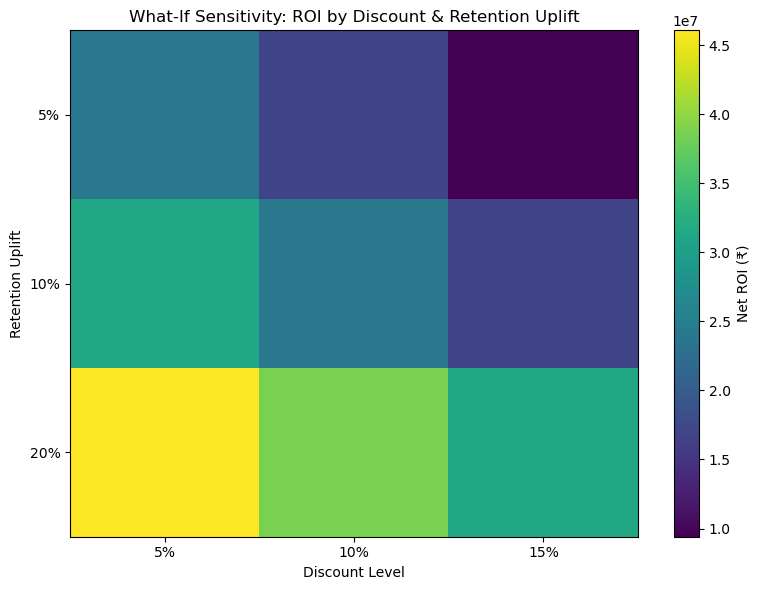

In [6]:
# ============================================================
# 💡 Plot: What-If Sensitivity Heatmap
# ============================================================

plt.figure(figsize=(8,6))
plt.imshow(roi_matrix, cmap="viridis", aspect="auto")
plt.colorbar(label="Net ROI (₹)")
plt.xticks(ticks=range(len(discount_rates)),
           labels=[f"{int(d*100)}%" for d in discount_rates])
plt.yticks(ticks=range(len(uplift_rates)),
           labels=[f"{int(u*100)}%" for u in uplift_rates])
plt.title("What-If Sensitivity: ROI by Discount & Retention Uplift")
plt.xlabel("Discount Level")
plt.ylabel("Retention Uplift")
plt.tight_layout()
plt.savefig("roi_sensitivity_heatmap.png", dpi=300)
plt.show()

In [7]:
# ============================================================
# 📋 Strategic Summary Table
# ============================================================

summary = []
for u in uplift_rates:
    for d in discount_rates:
        roi = compute_roi(u, d)
        summary.append({
            "Uplift (%)": int(u*100),
            "Discount (%)": int(d*100),
            "Net ROI (₹)": round(roi, 2),
            "Recommendation": (
                "High ROI — Recommend campaign"
                if roi > 0 else "Low ROI — Not cost-effective"
            )
        })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values("Net ROI (₹)", ascending=False)

# Save results
summary_df.to_csv("roi_summary_table.csv", index=False)
roi_matrix.to_csv("roi_sensitivity_matrix.csv")

print(" ROI simulation complete. Files saved:")
print(" - roi_sensitivity_heatmap.png")
print(" - roi_summary_table.csv")
print(" - roi_sensitivity_matrix.csv")

display(summary_df.head(6))

 ROI simulation complete. Files saved:
 - roi_sensitivity_heatmap.png
 - roi_summary_table.csv
 - roi_sensitivity_matrix.csv


,Uplift (%),Discount (%),Net ROI (₹),Recommendation
6,20,5,46091304.56,High ROI — Recommend campaign
7,20,10,38754054.56,High ROI — Recommend campaign
3,10,5,31416804.56,High ROI — Recommend campaign
8,20,15,31416804.56,High ROI — Recommend campaign
0,5,5,24079554.56,High ROI — Recommend campaign
4,10,10,24079554.56,High ROI — Recommend campaign
